# Reinforcement Learning 2025 - Final Assignment

**Authors:** Amit Ezer, Gal Yaacov Noy.

In [7]:
!pip install minigrid gymnasium matplotlib

In [ ]:
import os
import random
import itertools
import time
import csv
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import minigrid
from collections import deque
from gymnasium.vector import SyncVectorEnv
from IPython.display import display
from shared_utils import device, set_seeds, preprocess, create_env, QNetwork, ActorCritic

set_seeds(42)

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True  # Best for fixed-size inputs
torch.backends.cudnn.enabled = True    # Ensures cuDNN is used

Using device: cuda


## DoubleDQN

In [9]:
class ReplayBuffer:
    """Experience replay buffer for DQN."""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.stack(states).to(device),
            torch.stack(actions).to(device),
            torch.stack(rewards).to(device),
            torch.stack(next_states).to(device),
            torch.stack(dones).to(device),
        )

    def __len__(self):
        return len(self.buffer)

def select_action(model, state, epsilon, num_actions):
    """
    Selects an action using an epsilon-greedy strategy:
    - With probability `epsilon`, a random action is chosen (exploration).
    - With probability `1 - epsilon`, the action with the highest Q-value is chosen (exploitation).
    """
    if random.random() < epsilon:
        return torch.tensor([random.randint(0, num_actions - 1)], device=device)
    with torch.no_grad():
        q_values = model(state.unsqueeze(0))
        return q_values.argmax(dim=1)

In [ ]:
def train_double_dqn(
    env_name="MiniGrid-Dynamic-Obstacles-16x16-v0",
    num_episodes=4,
    max_steps=500,             
    batch_size=64,
    gamma=0.99,
    lr=1e-4,
    target_update_freq=1000,
    replay_capacity=100_000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995
):
    env = create_env(env_name)

    num_actions = env.action_space.n
    obs, _ = env.reset()
    input_size = obs.shape[0]

    # Models
    policy_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=replay_capacity)

    # Tracking
    episode_rewards = []
    episode_lengths = []
    losses = []
    epsilons = []
    global_step = 0
    epsilon = epsilon_start

    print(f"\n{'='*60}")
    print(f"TRAINING DOUBLE DQN ON {env_name.upper()}")
    print(f"{'='*60}")
    print(f"Episodes: {num_episodes} | Batch Size: {batch_size} | Learning Rate: {lr}")
    print(f"Gamma: {gamma} | Target Update: {target_update_freq} | Replay Capacity: {replay_capacity:,}")
    print(f"Epsilon: {epsilon_start} -> {epsilon_end} (decay: {epsilon_decay})")
    print(f"{'='*60}")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = preprocess(obs).to(device)
        total_reward = 0
        steps = 0

        for _ in range(max_steps):
            action = select_action(policy_net, state, epsilon, num_actions)

            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            next_state = preprocess(next_obs).to(device)
            done = terminated or truncated

            # Store transition
            transition = (
                state.detach(),
                torch.tensor([action.item()], dtype=torch.long, device=device),
                torch.tensor([reward], dtype=torch.float32, device=device),
                next_state.detach(),
                torch.tensor([done], dtype=torch.float32, device=device)
            )
            replay_buffer.push(transition)

            state = next_state
            total_reward += reward
            steps += 1
            global_step += 1

            # Train step
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Current Q-values for taken actions
                q_values = policy_net(states).gather(1, actions.view(-1, 1)).squeeze()

                with torch.no_grad():
                    # Double DQN: use policy network to select actions, target network to evaluate
                    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
                    next_q_values = target_net(next_states).gather(1, next_actions).squeeze()
                    targets = rewards.squeeze() + gamma * next_q_values * (1 - dones.squeeze())

                loss = F.mse_loss(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            # Learn
            if global_step % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        epsilons.append(epsilon)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if episode % 100 == 0:
            recent_rewards = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            recent_steps = np.mean(episode_lengths[-50:]) if len(episode_lengths) >= 50 else np.mean(episode_lengths)
            recent_loss = np.mean(losses[-100:]) if len(losses) >= 100 else (np.mean(losses) if losses else 0)
            print(f"[Double DQN] Ep {episode:4d} | Reward: {total_reward:6.2f} | Avg Reward: {recent_rewards:6.2f} | Steps: {steps:3d} | Avg Steps: {recent_steps:5.1f} | Epsilon: {epsilon:.3f} | Loss: {recent_loss:.4f}")

    env.close()

    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETED!")
    print(f"Final Average Reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.3f}")
    print(f"Final Average Steps (last 100 episodes): {np.mean(episode_lengths[-100:]):.1f}")
    print(f"Total Training Steps: {global_step:,}")
    print(f"{'='*60}")

    return {
        "name": "Double DQN",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses,
        "epsilons": epsilons,
        "model": policy_net,
    }

## PPO

In [11]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    """
    Compute Generalized Advantage Estimation (GAE).
    
    Args:
        rewards: list of tensors (num_envs,)
        values: list of tensors (num_envs,) + 1 bootstrap value
        dones: list of tensors (num_envs,)
        gamma: discount factor
        lam: GAE parameter
        
    Returns:
        tensor of shape (T, num_envs)
    """
    advs = []
    gae = torch.zeros_like(rewards[0]).to(device)

    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advs.insert(0, gae)

    return torch.stack(advs).to(device)

In [ ]:
def initialize_model(envs, input_size, lr, device):
    num_actions = envs.single_action_space.n
    model = ActorCritic(num_actions=num_actions, input_size=input_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, optimizer


def collect_rollouts(envs, model, states, max_steps, num_envs, gamma, lam, device, finished_episodes, total_episodes):
    # Buffers to store rollout data
    log_probs, actions, rewards, values, dones, state_buffer = [], [], [], [], [], []
    
    # Track rewards and lengths per environment
    ep_rewards = np.zeros(num_envs)
    ep_lengths = np.zeros(num_envs)
    episode_rewards, episode_lengths = [], []

    for _ in range(max_steps):
        with torch.no_grad():
            # Sample action and value from current policy
            action, log_prob, _ = model.get_action(states)
            _, value = model(states)

        next_obs, reward, terminated, truncated, _ = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        next_states = preprocess(next_obs, target_size=(56, 56)).to(device)

        state_buffer.append(states)
        actions.append(action.to(device))
        log_probs.append(log_prob)
        rewards.append(torch.tensor(reward, dtype=torch.float32, device=device))
        values.append(value.squeeze(-1))
        dones.append(torch.tensor(done, dtype=torch.float32, device=device))

        # Track per-environment episode stats
        for i in range(num_envs):
            ep_rewards[i] += reward[i]
            ep_lengths[i] += 1
            if done[i]:
                episode_rewards.append(ep_rewards[i])
                episode_lengths.append(ep_lengths[i])
                ep_rewards[i] = 0.0
                ep_lengths[i] = 0
                finished_episodes += 1

        states = next_states
        if finished_episodes >= total_episodes:
            break

    # Bootstrap final value for GAE
    with torch.no_grad():
        _, next_value = model(states)
    values.append(next_value.squeeze(-1))

    advantages = compute_gae(rewards, values, dones, gamma, lam)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    returns = advantages + torch.stack(values[:-1])

    # Flatten training data
    dataset = list(zip(
        torch.cat(state_buffer),
        torch.cat(actions),
        torch.cat(log_probs),
        returns.flatten(),
        advantages.flatten()
    ))

    return dataset, states, episode_rewards, episode_lengths, finished_episodes


def ppo_update(model, optimizer, dataset, update_epochs, minibatch_size, clip_eps, vf_coef, entropy_coef, device, losses, target_kl=None):
    for _ in range(update_epochs):
        random.shuffle(dataset)
        for i in range(0, len(dataset), minibatch_size):
            batch = dataset[i:i + minibatch_size]
            if len(batch) < minibatch_size:
                continue

            b_states, b_actions, b_old_log_probs, b_returns, b_advs = zip(*batch)
            b_states = torch.stack(b_states).to(device)
            b_actions = torch.stack(b_actions).to(device)
            b_old_log_probs = torch.stack(b_old_log_probs).to(device)
            b_returns = torch.stack(b_returns).to(device)
            b_advs = torch.stack(b_advs).to(device)

            # Evaluate model on batch
            log_probs, values, entropy = model.evaluate(b_states, b_actions)
            log_probs = log_probs.squeeze(-1)
            values = values.squeeze(-1)

            # Compute clipped policy loss
            ratio = torch.exp(log_probs - b_old_log_probs.squeeze(-1))
            surr1 = ratio * b_advs.squeeze(-1)
            surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * b_advs.squeeze(-1)
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Compute value function loss
            value_loss = F.mse_loss(values, b_returns.squeeze(-1))
            
            # Combine losses
            loss = policy_loss + vf_coef * value_loss - entropy_coef * entropy.mean()
            
            # Calculate KL divergence
            with torch.no_grad():
                log_ratio = log_probs - b_old_log_probs.squeeze(-1)
                approx_kl = ((torch.exp(log_ratio) - 1) - log_ratio).mean().item()

            if target_kl is not None and approx_kl > 1.5 * target_kl:
                print(f"[Early Stop] KL divergence {approx_kl:.4f} exceeded target {target_kl}")
                return  # Early stop PPO update

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            losses.append(loss.item())


def log_progress(finished_episodes, episode_rewards, episode_lengths, losses):
    recent_rewards = np.mean(episode_rewards[-50:]) if episode_rewards else 0
    recent_steps = np.mean(episode_lengths[-50:]) if episode_lengths else 0
    recent_loss = np.mean(losses[-100:]) if losses else 0
    print(f"[PPO] Ep {finished_episodes:4d} | Avg Reward: {recent_rewards:6.2f} | Avg Steps: {recent_steps:5.1f} | Loss: {recent_loss:.4f}")

def train_ppo(
    env_name="MiniGrid-Dynamic-Obstacles-16x16-v0",
    num_episodes=6,
    max_steps=500,
    num_envs=16,
    gamma=0.99,
    lam=0.95,
    clip_eps=0.2,
    lr=3e-4,
    update_epochs=4,
    minibatch_size=64,
    entropy_coef=0.01,
    vf_coef=0.5,
    target_kl=None
):
    
    # Create multiple parallel environments for vectorized rollout collection
    envs = SyncVectorEnv([lambda: create_env(env_name) for _ in range(num_envs)])
    
    obs, _ = envs.reset()
    states = preprocess(obs, target_size=(56, 56)).to(device)
    input_size = states.shape[1:][1]
    
    model, optimizer = initialize_model(envs, input_size, lr, device)

    # Tracks
    episode_rewards, episode_lengths, losses = [], [], []
    finished_episodes = 0
    
    print(f"\n{'='*60}")
    print(f"TRAINING PPO ON {env_name.upper()} WITH {num_envs} ACTORS")
    print(f"{'='*60}")
    print(f"Episodes: {num_episodes} | Max Steps: {max_steps} | Number of Environments: {num_envs}")
    print(f"Learning Rate: {lr} | Minibatch Size: {minibatch_size} | Clip Epsilon: {clip_eps}")
    print(f"Value Function Coef: {vf_coef} | Entropy Coef: {entropy_coef} | Update Epochs: {update_epochs}")
    print(f"Gamma: {gamma} | Lambda: {lam}")
    if target_kl is not None:
        print(f"Target KL Divergence: {target_kl}")
    print(f"{'='*60}")

    while finished_episodes < num_episodes:
        dataset, states, new_rewards, new_lengths, finished_episodes = collect_rollouts(
            envs, model, states, max_steps, num_envs, gamma, lam, device,
            finished_episodes, num_episodes
        )

        episode_rewards.extend(new_rewards)
        episode_lengths.extend(new_lengths)

        ppo_update(model, optimizer, dataset, update_epochs, minibatch_size,
                   clip_eps, vf_coef, entropy_coef, device, losses, target_kl)

        log_progress(finished_episodes, episode_rewards, episode_lengths, losses)

    envs.close()
    print(f"\n{'='*60}\nTRAINING COMPLETED!\n{'='*60}")

    return {
        "name": "PPO",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses,
        "model": model,
    }

## Experiments

In [13]:
EXPERIMENTS = {
    'Double DQN': train_double_dqn,
    'PPO': train_ppo
}

In [14]:
def export_model(model, name, env_name, models_dir="models"):
    """Export trained model to a file."""
    env_suffix = env_name.split('-')[-2].replace('v0', '').strip()
    model_dir = os.path.join(models_dir, env_suffix)
    
    os.makedirs(model_dir, exist_ok=True)
    
    filename = f"{name.replace(' ', '_').lower()}_model.pth"
    model_path = os.path.join(model_dir, filename)
    
    torch.save(model.state_dict(), model_path)
    print(f"Model exported to: {model_path}")
    return model_path

def plot_training_results(logs, window=50, title="Training Results"):
    """Plot training rewards, steps, losses and (optionally) epsilon decay."""

    def moving_average(data, window):
        if len(data) < window:
            return data
        return np.convolve(data, np.ones(window)/window, mode='valid')

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Episode Rewards
    axes[0, 0].plot(logs["rewards"], alpha=0.3, label="Raw", color='blue')
    if len(logs["rewards"]) >= window:
        smooth_rewards = moving_average(logs["rewards"], window)
        axes[0, 0].plot(range(window-1, len(logs["rewards"])), smooth_rewards,
                       label=f"Moving Avg ({window})", linewidth=2, color='red')
    axes[0, 0].set_title("Episode Rewards")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Episode Lengths
    axes[0, 1].plot(logs["steps"], alpha=0.3, label="Raw", color='green')
    if len(logs["steps"]) >= window:
        smooth_steps = moving_average(logs["steps"], window)
        axes[0, 1].plot(range(window-1, len(logs["steps"])), smooth_steps,
                       label=f"Moving Avg ({window})", linewidth=2, color='orange')
    axes[0, 1].set_title("Episode Length")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Steps")
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Loss
    if logs.get("losses"):
        axes[1, 0].plot(logs["losses"], alpha=0.6, color='purple')
        if len(logs["losses"]) >= window:
            smooth_loss = moving_average(logs["losses"], window)
            axes[1, 0].plot(range(window-1, len(logs["losses"])), smooth_loss,
                           label=f"Moving Avg ({window})", linewidth=2, color='red')
            axes[1, 0].legend()
        axes[1, 0].set_title("Training Loss")
        axes[1, 0].set_xlabel("Training Step")
        axes[1, 0].set_ylabel("Loss")
        axes[1, 0].grid(alpha=0.3)

    # Epsilon (if available)
    if "epsilons" in logs and logs["epsilons"]:
        axes[1, 1].plot(logs["epsilons"], color='brown', linewidth=2)
        axes[1, 1].set_title("Exploration Rate (Epsilon)")
        axes[1, 1].set_xlabel("Episode")
        axes[1, 1].set_ylabel("Epsilon")
        axes[1, 1].grid(alpha=0.3)
    else:
        axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

def print_performance_summary(logs):
    """Print performance summary."""
    print(f"\n{'='*60}")
    print(f"PERFORMANCE SUMMARY - {logs['name'].upper()}")
    print(f"{'='*60}")

    final_rewards = np.mean(logs["rewards"][-100:]) if len(logs["rewards"]) >= 100 else np.mean(logs["rewards"])
    best_rewards = max([np.mean(logs["rewards"][i:i+100]) for i in range(len(logs["rewards"])-99)]) if len(logs["rewards"]) >= 100 else max(logs["rewards"])
    final_steps = np.mean(logs["steps"][-100:]) if len(logs["steps"]) >= 100 else np.mean(logs["steps"])
    final_loss = np.mean(logs["losses"][-1000:]) if len(logs["losses"]) >= 1000 else (np.mean(logs["losses"]) if logs["losses"] else 0)

    print(f"Final Performance (last 100 episodes):")
    print(f"  Average Reward: {final_rewards:.3f}")
    print(f"  Average Steps: {final_steps:.1f}")
    print(f"  Training Loss: {final_loss:.4f}")
    print(f"\nBest Performance:")
    print(f"  Best 100-episode Average Reward: {best_rewards:.3f}")
    print(f"  Total Episodes: {len(logs['rewards'])}")
    print(f"  Total Training Steps: {len(logs['losses']):,}")
    print(f"{'='*60}")


In [15]:
def run_experiment(name, env_name="MiniGrid-Dynamic-Obstacles-16x16-v0", log_and_export=True, **kwargs):
    """Run complete experiment: train agent, analyze, and plot."""
    # Train agent
    out = EXPERIMENTS[name](env_name=env_name, **kwargs)

    if log_and_export:
        # Analyze and visualize
        print_performance_summary(out)
        plot_training_results(out, title=f"{name} Training Results")
        export_model(out["model"], name, env_name)

    return out

### Hyperparameters Tuning

In [16]:
HYPERPARAMETERS = {
    'Double DQN': {
        'lr': [1e-3, 3e-4],
        'target_update_freq': [1000, 2000],
        'batch_size': [32, 64],
    },
    'PPO': {
        'lr': [1e-3, 3e-4],
        'entropy_coef': [0.01, 0.0],
        'minibatch_size': [32, 64],
    }
}

In [17]:
def hyperparameters_tuning(name, env_name="MiniGrid-Dynamic-Obstacles-8x8-v0", num_episodes=2, output_file=None):
    hp_grid = HYPERPARAMETERS[name]
    hp_keys = list(hp_grid.keys())
    combinations = list(itertools.product(*[hp_grid[k] for k in hp_keys]))
    
    results = []

    print(f"\n{'='*60}")
    print(f"HYPERPARAMETERS TUNING FOR {name.upper()} ON {env_name.upper()}")
    print(f"Total combinations: {len(combinations)}")
    print(f"{'='*60}")
    
    for i, combo in enumerate(combinations):
        hp_args = dict(zip(hp_keys, combo))
        print(f"\n[{i+1}/{len(combinations)}] {name} with " + ", ".join(f"{k}={v}" for k, v in hp_args.items()))

        try:
            exp_logs = run_experiment(
                name,
                env_name=env_name,
                num_episodes=num_episodes,
                log_and_export=False,
                **hp_args
            )

            avg_reward = sum(exp_logs["rewards"][-100:]) / min(100, len(exp_logs["rewards"]))
            avg_steps = sum(exp_logs["steps"][-100:]) / min(100, len(exp_logs["steps"]))
            results.append(list(combo) + [round(avg_reward, 4), round(avg_steps, 2)])

            print("Success")

        except Exception as e:
            print(f"Failed: {e}")
            time.sleep(1)

    # Sort and export
    results.sort(key=lambda row: row[-2], reverse=True)

    if output_file is None:
        output_file = f"tuning/{name.lower().replace(' ', '_')}_tuning_results.csv"

    with open(output_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(hp_keys + ["avg_reward_last_100", "avg_steps_last_100"])
        writer.writerows(results)

    print(f"\n{'='*60}\nSaved summary to {output_file}\n{'='*60}")

In [18]:
hyperparameters_tuning("Double DQN")


HYPERPARAMETERS TUNING FOR DOUBLE DQN ON MINIGRID-DYNAMIC-OBSTACLES-8X8-V0
Total combinations: 8

[1/8] Double DQN with lr=0.001, target_update_freq=1000, batch_size=32

TRAINING DOUBLE DQN ON MINIGRID-DYNAMIC-OBSTACLES-8X8-V0
Episodes: 2 | Batch Size: 32 | Learning Rate: 0.001
Gamma: 0.99 | Target Update: 1000 | Replay Capacity: 100,000
Epsilon: 1.0 -> 0.05 (decay: 0.995)
[2025-07-28 00:45:10] [Double DQN] Ep    0 | Reward:  -1.00 | Avg Reward:  -1.00 | Steps:   3 | Avg Steps:   3.0 | Epsilon: 0.995 | Loss: 0.0000

TRAINING COMPLETED!
Final Average Reward (last 100 episodes): -1.000
Final Average Steps (last 100 episodes): 13.5
Total Training Steps: 27
Success

[2/8] Double DQN with lr=0.001, target_update_freq=1000, batch_size=64

TRAINING DOUBLE DQN ON MINIGRID-DYNAMIC-OBSTACLES-8X8-V0
Episodes: 2 | Batch Size: 64 | Learning Rate: 0.001
Gamma: 0.99 | Target Update: 1000 | Replay Capacity: 100,000
Epsilon: 1.0 -> 0.05 (decay: 0.995)
[2025-07-28 00:45:11] [Double DQN] Ep    0 | Rewar

In [19]:
def show_tuning_results(name):
    filename = f"tuning/{name.lower().replace(' ', '_')}_tuning_results.csv"
    df = pd.read_csv(filename)
    df.columns = [col.replace('_', ' ').title() for col in df.columns]
    display(df)

print("\nTuning Results for Double DQN:")
show_tuning_results("Double DQN")


Tuning Results for Double DQN:


,Lr,Target Update Freq,Batch Size,Avg Reward Last 100,Avg Steps Last 100
0,0.0010,1000,32,-1.0,13.5
1,0.0010,1000,64,-1.0,17.0
2,0.0010,2000,32,-1.0,6.0
3,0.0010,2000,64,-1.0,6.5
4,0.0003,1000,32,-1.0,9.5
5,0.0003,1000,64,-1.0,16.5
6,0.0003,2000,32,-1.0,11.5
7,0.0003,2000,64,-1.0,13.5



TRAINING DOUBLE DQN ON MINIGRID-DYNAMIC-OBSTACLES-16X16-V0
Episodes: 4 | Batch Size: 32 | Learning Rate: 0.0003
Gamma: 0.99 | Target Update: 2000 | Replay Capacity: 100,000
Epsilon: 1.0 -> 0.05 (decay: 0.995)
[2025-07-28 00:45:12] [Double DQN] Ep    0 | Reward:  -1.00 | Avg Reward:  -1.00 | Steps:  94 | Avg Steps:  94.0 | Epsilon: 0.995 | Loss: 0.0009

TRAINING COMPLETED!
Final Average Reward (last 100 episodes): -1.000
Final Average Steps (last 100 episodes): 32.2
Total Training Steps: 129

PERFORMANCE SUMMARY - DOUBLE DQN
Final Performance (last 100 episodes):
  Average Reward: -1.000
  Average Steps: 32.2
  Training Loss: 0.0070

Best Performance:
  Best 100-episode Average Reward: -1.000
  Total Episodes: 4
  Total Training Steps: 98


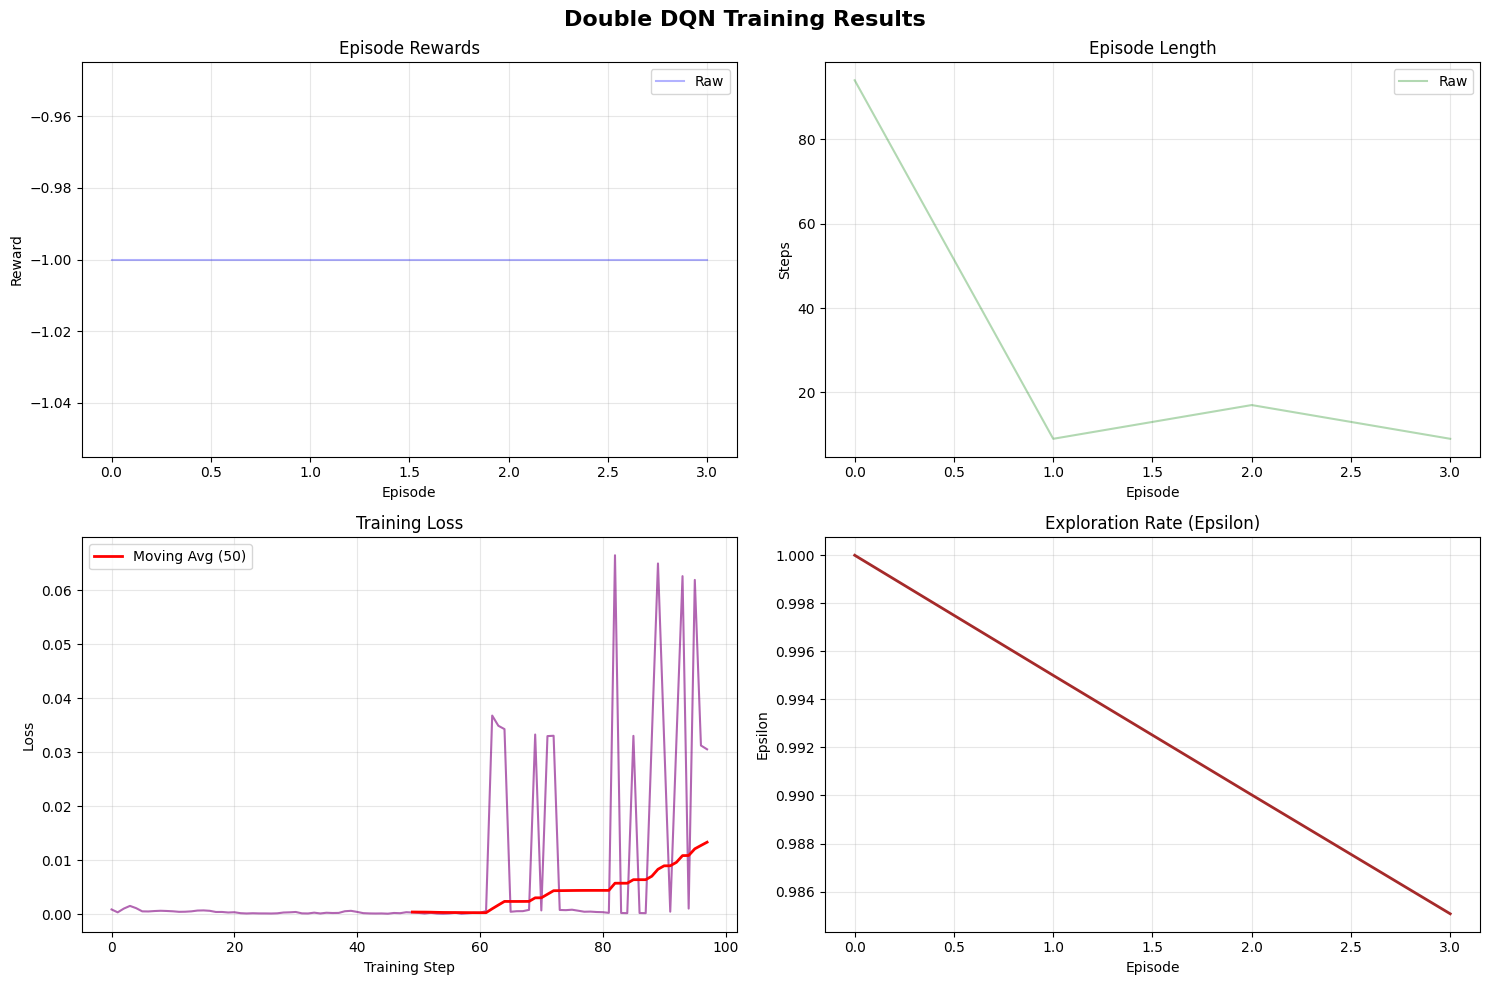

Model exported to: models/16x16/double_dqn_model.pth


In [20]:
dqn_out = run_experiment("Double DQN", lr=3e-4, target_update_freq=2000, batch_size=32)

In [21]:
hyperparameters_tuning("PPO", num_episodes=3)


HYPERPARAMETERS TUNING FOR PPO ON MINIGRID-DYNAMIC-OBSTACLES-8X8-V0
Total combinations: 8

[1/8] PPO with lr=0.001, entropy_coef=0.01, minibatch_size=32

TRAINING PPO ON MINIGRID-DYNAMIC-OBSTACLES-8X8-V0 WITH 16 ACTORS
Episodes: 3 | Max Steps: 500 | Number of Environments: 16
Learning Rate: 0.001 | Minibatch Size: 32 | Clip Epsilon: 0.2
Value Function Coef: 0.5 | Entropy Coef: 0.01 | Update Epochs: 4
Gamma: 0.99 | Lambda: 0.95
[2025-07-28 00:45:14] [PPO] Ep    3 | Avg Reward:  -1.00 | Avg Steps:   2.0 | Loss: 0.4505

TRAINING COMPLETED!
Success

[2/8] PPO with lr=0.001, entropy_coef=0.01, minibatch_size=64

TRAINING PPO ON MINIGRID-DYNAMIC-OBSTACLES-8X8-V0 WITH 16 ACTORS
Episodes: 3 | Max Steps: 500 | Number of Environments: 16
Learning Rate: 0.001 | Minibatch Size: 64 | Clip Epsilon: 0.2
Value Function Coef: 0.5 | Entropy Coef: 0.01 | Update Epochs: 4
Gamma: 0.99 | Lambda: 0.95
[2025-07-28 00:45:14] [PPO] Ep    3 | Avg Reward:  -1.00 | Avg Steps:   2.0 | Loss: 0.0000

TRAINING COMPLE

In [22]:
print("\nTuning Results for PPO:")
show_tuning_results("PPO")


Tuning Results for PPO:


,Lr,Entropy Coef,Minibatch Size,Avg Reward Last 100,Avg Steps Last 100
0,0.0010,0.01,32,-1.0,2.00
1,0.0010,0.01,64,-1.0,2.00
2,0.0010,0.00,32,-1.0,2.50
3,0.0010,0.00,64,-1.0,2.33
4,0.0003,0.01,32,-1.0,2.33
5,0.0003,0.01,64,-1.0,2.00
6,0.0003,0.00,32,-1.0,2.75
7,0.0003,0.00,64,-1.0,2.75



TRAINING PPO ON MINIGRID-DYNAMIC-OBSTACLES-16X16-V0 WITH 16 ACTORS
Episodes: 6 | Max Steps: 500 | Number of Environments: 16
Learning Rate: 0.0003 | Minibatch Size: 64 | Clip Epsilon: 0.2
Value Function Coef: 0.5 | Entropy Coef: 0.0 | Update Epochs: 4
Gamma: 0.99 | Lambda: 0.95
[2025-07-28 00:45:15] [PPO] Ep    6 | Avg Reward:  -1.00 | Avg Steps:   2.0 | Loss: 0.0000

TRAINING COMPLETED!

PERFORMANCE SUMMARY - PPO
Final Performance (last 100 episodes):
  Average Reward: -1.000
  Average Steps: 2.0
  Training Loss: 0.0000

Best Performance:
  Best 100-episode Average Reward: -1.000
  Total Episodes: 6
  Total Training Steps: 0


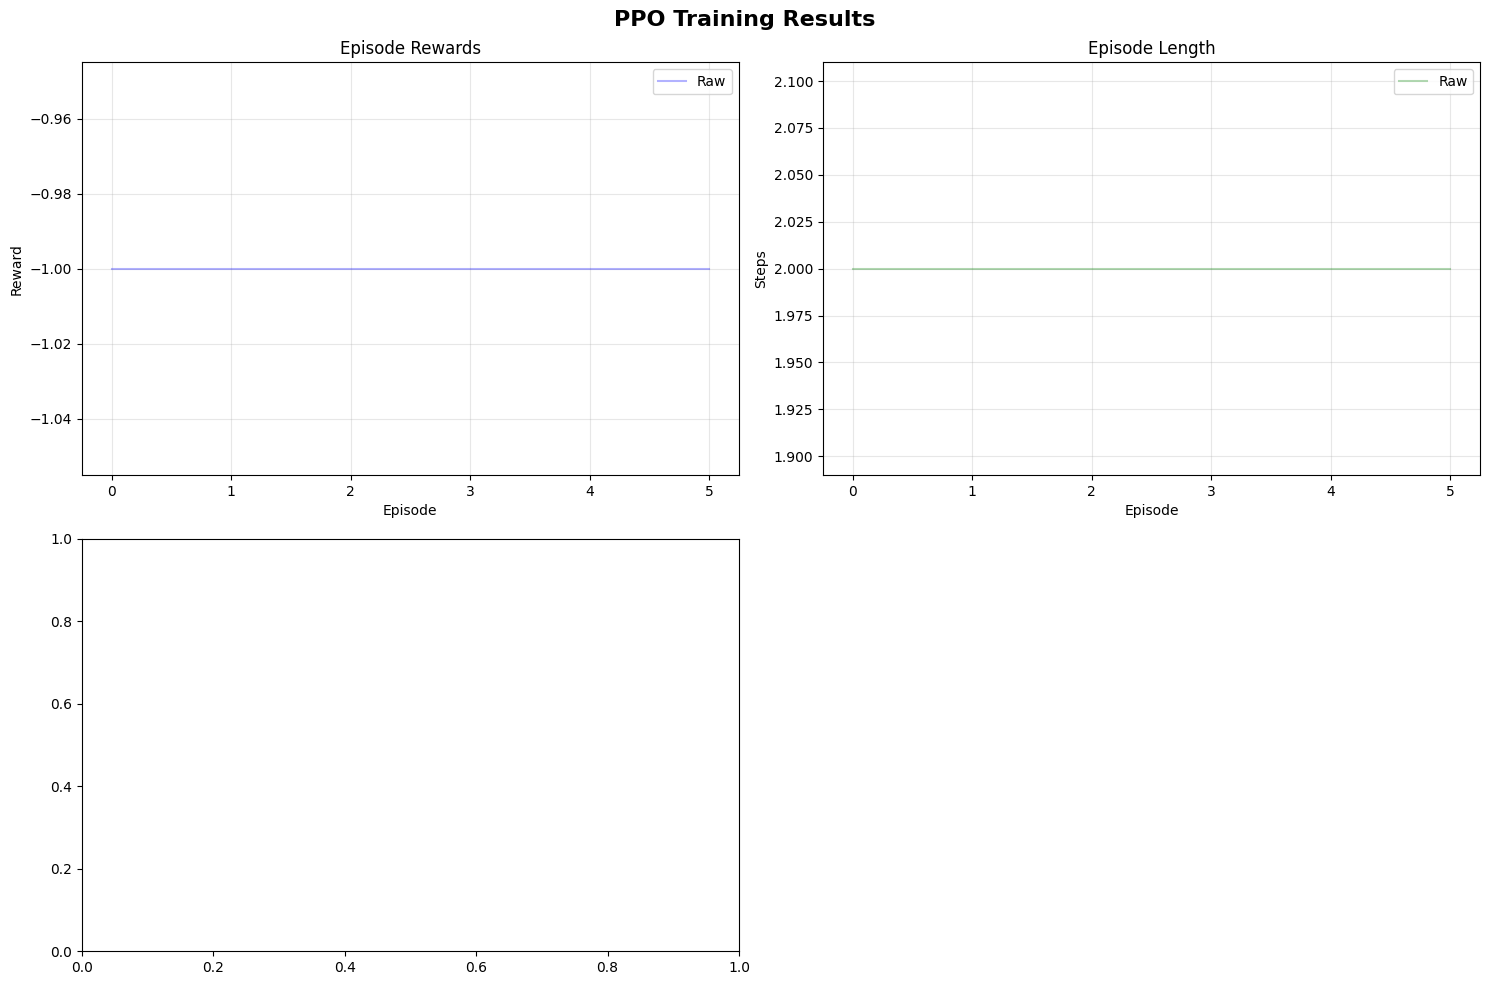

Model exported to: models/16x16/ppo_model.pth


In [23]:
ppo_out = run_experiment("PPO", lr=3e-4, entropy_coef=0.0, minibatch_size=64)